In [15]:
import numpy as np
import pandas as pd
import yfinance as yf
import statsmodels.api as sm
import riskfolio as rp

import matplotlib.pyplot as plt

from pandas_datareader import data as web

In [3]:
start = '2016-01-01'
end = '2019-12-30'

tickers = pd.read_excel('/Users/professortu/Documents/GFE/17. ATFE /Python Programs/SandP500list.xlsx')

names = tickers[tickers['sector']=='Real Estate'] # if wish to focus on a certain sector 

ticker_all = tickers['symbol'].to_list()

In [5]:
data = pd.read_csv('/Users/professortu/Documents/GFE/17. ATFE /Python Programs/all_data.csv')
data.index = data['Date']
data.drop('Date', axis=1, inplace=True)

assets = data.columns.to_list()[0:30]

Y = data[assets].pct_change().dropna()

port = rp.Portfolio(returns=Y)

method_mu = 'hist'
method_cov = 'hist'

port.assets_stats(method_mu=method_mu, 
                  method_cov=method_cov)

model = 'Classic'
rm = 'MV'
obj = 'Sharpe'
hist = True
rf = 0.04/12/22
l = 0

w = port.optimization(model=model,
                      rm=rm,
                      obj=obj,
                      rf=rf,
                      l=l,
                      hist=hist)

print(w)

           weights
A     1.033424e-10
AAL   3.346937e-11
AAP   8.056609e-11
AAPL  4.622172e-02
ABBV  3.630934e-02
ABT   8.811409e-10
ACN   1.396855e-10
ADBE  8.429737e-02
ADI   1.181775e-10
ADM   8.683880e-11
ADP   1.806743e-09
ADSK  2.879140e-09
AEE   5.858000e-02
AEP   1.608643e-01
AES   1.556878e-09
AFL   1.334434e-01
AIG   4.820785e-11
AIZ   1.878883e-02
AJG   3.313110e-01
AKAM  9.949740e-02
ALB   4.852986e-11
ALGN  1.141190e-10
ALK   4.971834e-11
ALL   2.074669e-10
ALLE  1.486887e-10
AMAT  2.014201e-10
AMCR  7.936941e-11
AMD   3.068665e-02
AME   1.053881e-10
AMGN  3.249585e-10


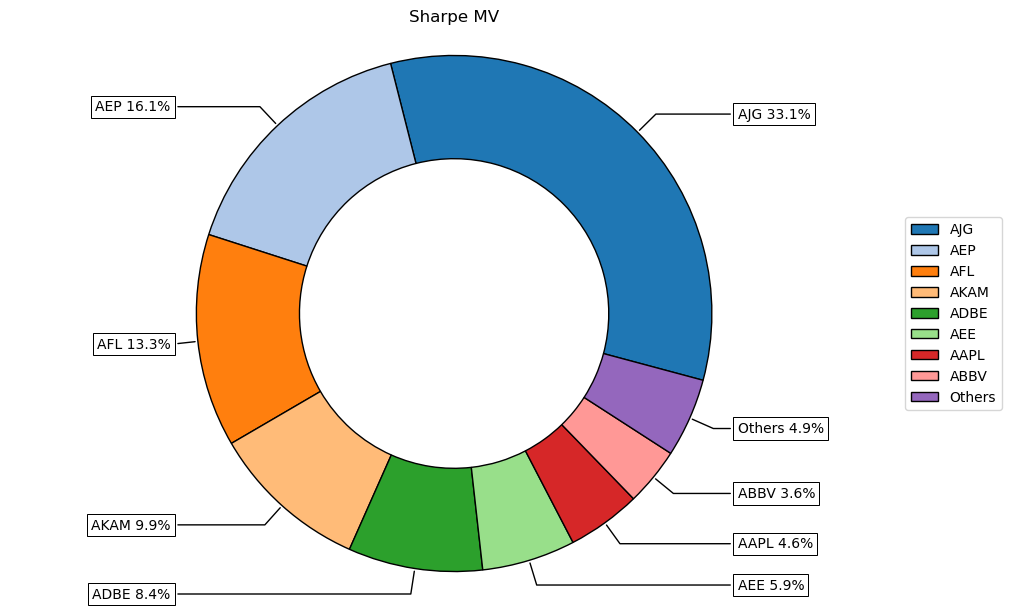

In [7]:
ax1 = rp.plot_pie(w=w, 
                  title='Sharpe MV',
                  others = 0.05,
                  nrow=20,
                  cmap='tab20',
                  height=6,
                  width=10,
                  ax=None)
plt.show()

# Efficient frontier

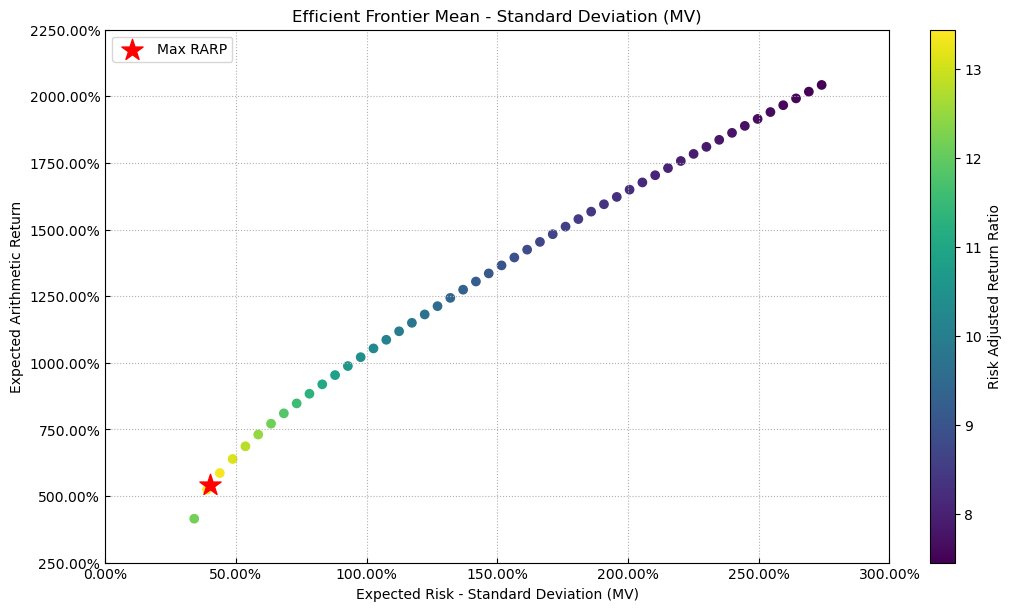

In [8]:
points = 50

frontier = port.efficient_frontier(model=model,
                                   rm=rm,
                                   points=points,
                                   rf=rf,
                                   hist=hist)
label = 'Max RARP'
mu = port.mu
cov = port.cov
returns = port.returns

ax2 = rp.plot_frontier(w_frontier=frontier, 
                       mu=mu,
                       cov=cov,
                       returns=returns,
                       rm=rm,
                       rf=rf,
                       alpha=0.05,
                       cmap='viridis',
                       w=w,
                       label=label,
                       marker='*',
                       s=16,
                       c='r',
                       height=6,
                       width=10,
                       ax=None)

### Here we estimate the covariance matrix using a simple CAPM framework and redo the previous exercise

In [17]:
# data s before
data = pd.read_csv('/Users/professortu/Documents/GFE/17. ATFE /Python Programs/all_data.csv')
data.index = data['Date']
data.drop('Date', axis=1, inplace=True)

# market index prices
m = pd.DataFrame(yf.download('^NYA',
                             start=start,
                             end=end,
                             interval='1mo')['Close'])

m = m.set_index(data.index)

tbill = web.get_data_fred('TB3MS', start=start, end=end)
tbill = tbill.set_index(data.index)

data['market'] = m['^NYA']

ret = data[assets].pct_change()
ret['m'] = data['market'].pct_change()
ret['tbill'] = tbill['TB3MS']/12/100

ret.dropna(axis=0, inplace=True)

num_assets = len(assets)

beta_m = np.zeros((num_assets, 1))
sig2e = np.zeros((num_assets,1))

ret['mer'] = ret['m'] - ret['tbill']
i = 0
for asset in assets:
    y = ret[asset] - ret['tbill']
    modeli = sm.OLS(y, sm.add_constant(ret['mer'])).fit()
    beta_m[i] = modeli.params['mer']
    sig2e[i] = np.var(modeli.resid)
    i = i + 1
    
sig2f = np.var(ret['mer'])

COV_capm = np.zeros((num_assets, num_assets))

for i in range(num_assets): 
    for j in range(num_assets):
        COV_capm[i,j] = beta_m[i]*beta_m[j]*sig2f
        if i==j:
            COV_capm[i,i] = COV_capm[i,i] + sig2e[i]
        
COV_input = pd.DataFrame(COV_capm)
COV_input.columns = assets

mean_ret = np.array(np.mean(ret[assets]))

port_2 = rp.Portfolio(returns=ret[assets])

port_2.mu = mean_ret
port_2.cov = COV_input    

model = 'Classic'
rm = 'MV'   # Mean-Variance optimization
obj = 'Sharpe'
hist = True
rf = 0.04/12/22
l = 0

w_2 = port.optimization(model=model,
                      rm=rm,
                      obj=obj,
                      rf=rf, 
                      l=l,
                      hist=hist)

print(w_2)

[*********************100%***********************]  1 of 1 completed


           weights
A     1.033424e-10
AAL   3.346937e-11
AAP   8.056609e-11
AAPL  4.622172e-02
ABBV  3.630934e-02
ABT   8.811409e-10
ACN   1.396855e-10
ADBE  8.429737e-02
ADI   1.181775e-10
ADM   8.683880e-11
ADP   1.806743e-09
ADSK  2.879140e-09
AEE   5.858000e-02
AEP   1.608643e-01
AES   1.556878e-09
AFL   1.334434e-01
AIG   4.820785e-11
AIZ   1.878883e-02
AJG   3.313110e-01
AKAM  9.949740e-02
ALB   4.852986e-11
ALGN  1.141190e-10
ALK   4.971834e-11
ALL   2.074669e-10
ALLE  1.486887e-10
AMAT  2.014201e-10
AMCR  7.936941e-11
AMD   3.068665e-02
AME   1.053881e-10
AMGN  3.249585e-10


/var/folders/lm/p42kz6cs7fs357mxprjc7kq40000gn/T/ipykernel_49018/140398219.py:45: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  COV_capm[i,j] = beta_m[i]*beta_m[j]*sig2f
/var/folders/lm/p42kz6cs7fs357mxprjc7kq40000gn/T/ipykernel_49018/140398219.py:47: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  COV_capm[i,i] = COV_capm[i,i] + sig2e[i]


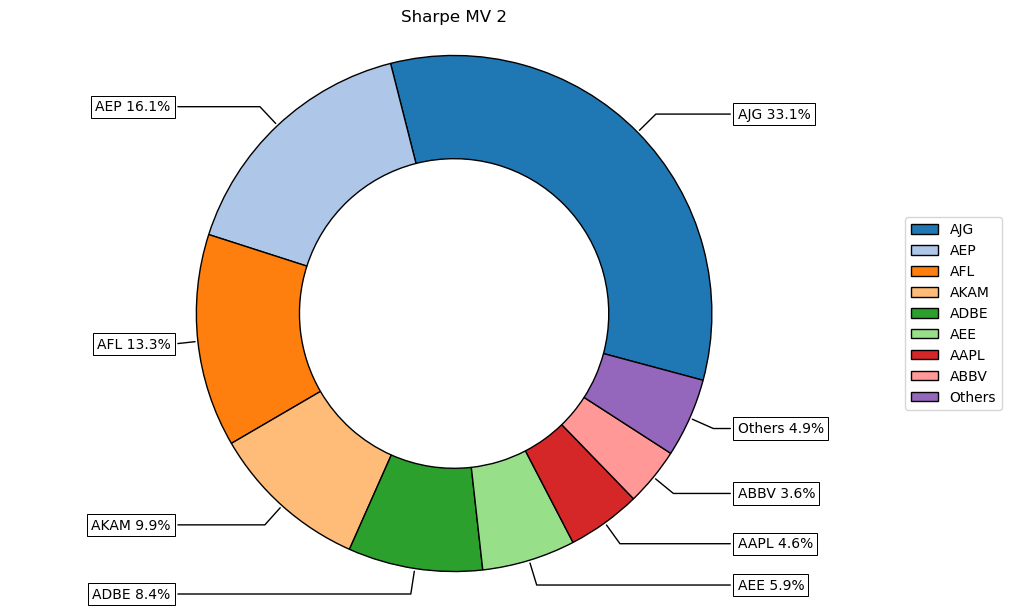

In [18]:
ax1 = rp.plot_pie(w=w_2,
                  title='Sharpe MV 2',
                  others = 0.05,
                  nrow = 20,
                  cmap = 'tab20',height=6,
                  width=10, ax=None)

plt.show()